FURB - UNIVERSIDADE REGIONAL DE BLUMENAU

Especialização em Data Science - Turma 2

Disciplina: Deep Learning

**Nome: Marcus Moresco Boeno**

O presente estudo foi desenvolvido como atividade final da disciplina de Deep Learning da Pós-Graduação em Data Science da FURB (Universidade Regional de Blumenau).

A atividade consiste no desenvolvimento e teste de uma arquitetura de rede neural recorrente para a classificação de sentimento em críticas de filmes utilizando o framework [PyTorch](https://pytorch.org/).

O dataset utilizado é composto por 50 mil revisões de filmes na plataforma [IMDB](https://ai.stanford.edu/~amaas/data/sentiment/), sendo disponibilizado por meio do próprio PyTorch pela classe `torchtext.datasets.IMDB()`.

A rede neural construída se trata de uma arquitetura do tipo recorrente com células LSTM seguidas de uma camada de dropout e uma camada totalmente conectada para predição da classe (sentimento) da revisão. A rede é alimentada com sequencias de tokens mapeados para vetores densos de 30 dimensões por um modelo Word2Vec treinado com a própria base de dados. 

A rede está estruturada da seguinte maneira:

- Camada de Embedding com vetores treinados com modelo Word2Vec;
- Camada Recorrente LSTM com inicialização Xavier;
- Camada Dropout com manutenção de 50% dos neurônios;
- Camada totalmente conectada com ativação sigmoidal.

A seguir são apresentados os passos de pré-processamento, desenvolvimento da rede e otimização de hiperparâmetros, sendo que o presente notebook está estruturado da seguinte forma:

Estrutura do Notebook
- Importando bibliotecas
- Leitura da Base de Dados
- Pré-Processamento
    - Tokenização, lematização e remoção de tags HTML, pontuação e stopwords
    - Detecção e mapeamento de palavras compostas
    - Treinamento de modelo Word2Vec
    - Definição da matriz de vetores densos
    - Mapeamento de tokens para índices e aplicação de padding
- Definição dos conjuntos de treino, validação e teste
- Implementação de Rede Neural LSTM
- Treinamento e otimização de hiperparâmetros
- Análise de acurácia
- Carregando o modelo treinado e realizando classificações


## Importando bibliotecas
---

Em um primeiro momento foram carregadas bibliotecas, classes e métodos para manipulação dos dados e implementação da rede neural.

A rede será implementada com o auxílio do framework [PyTorch](https://pytorch.org/). 

As bibliotecas `NumPy`, `Pandas`, `random` e `pickle` serão utilizadas para leitura/export do dataset e manipulação de dataframes e arrays.

As bibliotecas `random`, `re`, `nltk` e `BeatifulSoup` serão utilizadas nas etapas de pré-processamento das reviews.

A biblioteca `gensim` será utilizada para o treinamento de um modelo Word2Vec e a composição do vocabulário a ser inserido no modelo.

A biblioteca `Scikit-learn` será utilizada para auxílido nas etapas de obteção de conjuntos de treinamento e validação (método `train_test_split`).

A biblioteca `optuna` será utilizada para a etapa de otimização dos hiperparâmetros da rede LSTM.

Por fim, a biblioteca `pickle` servirá como base para o registro dos resultados do experimento como arquivos binários com a extensão ".pkl". Dessa forma, etapas do experimento podem carregadas facilmente em rotinas futuras.


In [13]:

# Import para download da base de dados IMDB
from torchtext import datasets

# Imports para pré-processamento das strings
import random
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Imports para captura de palavras compostas e word embedding
from gensim.models import Word2Vec, Phrases

# Manipulação de strings, arrays e dataframes
import numpy as np
import pandas as pd
from glob import glob
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math

# Import do PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Import do Optuna para otimimização de hiperparâmetros
import optuna


[nltk_data] Downloading package stopwords to /home/marcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Leitura da Base de Dados
---

Após realizar o download e descompactar o dataset com o método torchtext.datasets.IMDB(), carregamos os dados diretamente dos arquivos txt em um pandas Dataframe. Em um primeiro momento não utilizaremos iteradores para termos maior flexibilidade no desenvolvimento e aplicação dos métodos de pré-processamento.


In [2]:

def load_data() -> pd.DataFrame:
    """Leitura de Reviews do IMDB

    > Argumentos:
        - Sem argumentos
    
    > Outputs:
        - (pd.DataFrame): Dataframe com reviews presentes no dataset
    """
    
    # Recupera lista de arquivos
    files = glob('.data/IMDB/aclImdb/train/neg/*.txt')
    files.extend(glob('.data/IMDB/aclImdb/train/pos/*.txt'))
    files.extend(glob('.data/IMDB/aclImdb/test/neg/*.txt'))
    files.extend(glob('.data/IMDB/aclImdb/test/pos/*.txt'))
    random.shuffle(files)
    
    # Carrega dados em forma de dicionário
    reviews_dict = {k:[] for k in ['filename', 'usage', 'sent', 'text']}
    for f in files:
        _, _, _, use, sent, fname = f.split('/')
        reviews_dict['filename'].append(fname)
        reviews_dict['usage'].append(use)
        reviews_dict['sent'].append(sent)
        with open(f, 'r') as g:
            phrase = g.read()
        reviews_dict['text'].append(phrase)
    reviews = pd.DataFrame(reviews_dict)
    reviews = reviews.sample(frac=1).reset_index(drop=True)    

    # Retorna dados
    return reviews

# Carrega dataset de reviews do IMDB
imdb_reviews = load_data()

# Apresenta head e tail do dataframe
imdb_reviews


,filename,usage,sent,text
0,494_9.txt,train,pos,This is the start of a new and interesting Sta...
1,11293_3.txt,train,neg,This movie was a real torture fest to sit thro...
2,6429_1.txt,test,neg,What can be said about such a pathetic movie ?...
3,9913_8.txt,test,pos,Kirk and the crew are visiting a federation mi...
4,4421_4.txt,train,neg,The subject is certainly compelling: a group o...
...,...,...,...,...
49995,4384_10.txt,train,pos,MAJOR SPOILERS!! THIS IS FOR PEOPLE WHO HAVE S...
49996,5438_3.txt,train,neg,I am quite a fan of novelist/screenwriter Mich...
49997,7743_7.txt,test,pos,For many years I thought I was the only person...
49998,3084_10.txt,test,pos,Cary Elwes have to say puts on a better perfor...


O dataset é composto de 50000 revisões de filmes realizadas no portal IMDB, sendo 25000 classificadas como "positiva" e 25000 como "negativa". Cada grupo ainda é subdivido em 12500 amostras para treino e 12500 para teste. 

## Pré-processamento
---

O pré-processamento é uma etapa muito importante no desenvolvimento de um modelo de classificação de texto. Aqui vamos retirar do dataset caracteres irrelevantes como tags HTML, pontuações e palavras que possuem pouco valor semântico (stopwords). Dessa forma realizamos uma "limpeza" no dataset, entregando ao modelo apenas palavras que tenham mais imporância para a análise de sentimento.

Também realizaremos a detecção e mapeamento de palavras compostas dentro do dataset, visando incrementar o valor semântico do vocabulário usado para o treinamento da rede neural.

Após as etapas de pré-processamento iremos realizar o treinamento de um modelo Word2Vec para transformarmos palavras em vetores densos n-dimensionais, para que a rede neural possa interpretar as frases que compõem cada revisão.


### Tokenização, lematização e remoção de tags HTML, pontuação e stopwords
---

In [3]:

# Compila regex para caracteres
CHAR_REGEX = re.compile(r'[^A-Za-z\s]')

def sentence_cleaning(txt:str):
    """Realiza limpeza das frases"""

    # Remove tags HTML
    txt = BeautifulSoup(txt, "html.parser")
    txt = txt.get_text()

    # Recupera apenas letras
    txt = CHAR_REGEX.sub(" ", txt)

    # Passa todos os caracteres para letras minúsculas
    txt = txt.lower().strip()

    # Cria tokens
    txt =  word_tokenize(txt, "english")

    # Realiza lemmatize para cada palavra
    lem = WordNetLemmatizer()
    txt = [lem.lemmatize(w, pos='v') for w in txt]

    # Remove stopwords
    txt = [w for w in txt if w not in stopwords.words('english')]
    
    # Retorna texto
    return " ".join(txt)


# Realiza primeira etapa do pré-processamento das reviews
imdb_reviews['text_clean'] = imdb_reviews['text'].apply(sentence_cleaning)

# Apresenta primeiras linhas
imdb_reviews.head()


,filename,usage,sent,text,text_clean
0,494_9.txt,train,pos,This is the start of a new and interesting Sta...,start new interest star trek series earth kind...
1,11293_3.txt,train,neg,This movie was a real torture fest to sit thro...,movie real torture fest sit first mistake trea...
2,6429_1.txt,test,neg,What can be said about such a pathetic movie ?...,say pathetic movie bad act main actress seem k...
3,9913_8.txt,test,pos,Kirk and the crew are visiting a federation mi...,kirk crew visit federation mine colony remote ...
4,4421_4.txt,train,neg,The subject is certainly compelling: a group o...,subject certainly compel group people take lov...


In [4]:

# Exemplo do output da primeira etapa de pré-processamento 
print("Exemplo do output da primeira etapa de pré-processamento\n")
print("Frase Original:")
print(imdb_reviews.iloc[0, 3])
print("\nFrase após primeira etapa de pré-processamento:")
print(imdb_reviews.iloc[0, 4])


Exemplo do output da primeira etapa de pré-processamento

Frase Original:
This is the start of a new and interesting Star Trek series. It has a "down to earth"-kind of feel with darker and less "plaggy" scenography.<br /><br />The characters need some more time to develop but they have potential. One thing that is fairly disappointing (with all Star Trek series really) is that they portray such a gloomy picture of the equality between men and women in the future when they paint a very positive picture about everything else. (Earth has stopped war, famine etc)<br /><br /> The female characters here are two, subcommander T'Pol who is vulcan and communications officer Hoshi who is human. Hoshi is quite wimpy and T'Pol is made to be a "vulcan babe".<br /><br /> Some of the crew attitudes feel a bit too American (as opposed to the more international feel of the TNG-crew) but creates interesting dynamics.<br /><br /> A very good pilot though for a very good series.

Frase após primeira etapa

### Detecção e mapeamento de palavras compostas
---

Agora, vamos utilizar a classe Phrases do Gensim, para capturar palavras compostas com comprimento de até três palavras. Com isso, os tokens "new" e "york", serão unidos como "new_york", assim como os tokes "new", "york" e "city" serão unidos como "new_york_city". Isso ajudará o nosso modelo a entender o contexto e a semântica de palavras compostas. Entretanto é válido salientar que o Gensim só irá reconhecer palavras compostas se eles tiverem grande frequência dentro da base de dados. Por exemplo, se as palavras "star" e "wars" aparecerem em sequencia frequentemente nas frases, o Gensim vai enteder que os tokens "star" e "wars" devem ser unidos em um token composto ("star_wars") quando aparecerem juntos. Dai a importância de uma base de dados extensa para o treinamento dos modelos.

In [6]:

# Cria modelo para bigrams
bigrams = Phrases(
    sentences=imdb_reviews['text_clean'].apply(
        lambda x: x.split()
    ).values
)

# Cria modelo para trigrams 
trigrams = Phrases(
    sentences=bigrams[imdb_reviews['text_clean'].apply(
        lambda x: x.split()
    ).values]
)

# Exportando bigrams para eventual leitura
with open("pkl/bigrams.pkl", "wb") as f:
    f.write(pickle.dumps(bigrams))

# Exportando trigrams para eventual leitura
with open("pkl/trigrams.pkl", "wb") as f:
    f.write(pickle.dumps(trigrams))

# Exemplo união de palavras compostas
frase1 = 'the new york city skyline is amazing'
frase2 = 'ewan mcgregor plays obiwan kenoni in star wars'

print(f"\nOriginal: {frase1}")
print(f"Modelo bigrams: {bigrams[frase1.split()]}")
print(f"Modelo trigrams: {trigrams[bigrams[frase1.split()]]}")

print(f"\nOriginal: {frase2}")
print(f"Modelo bigrams: {bigrams[frase2.split()]}")
print(f"Modelo trigrams: {trigrams[bigrams[frase2.split()]]}\n")



Original: the new york city skyline is amazing
Modelo bigrams: ['the', 'new_york', 'city', 'skyline', 'is', 'amazing']
Modelo trigrams: ['the', 'new_york_city', 'skyline', 'is', 'amazing']

Original: ewan mcgregor plays obiwan kenoni in star wars
Modelo bigrams: ['ewan_mcgregor', 'plays', 'obiwan', 'kenoni', 'in', 'star', 'wars']
Modelo trigrams: ['ewan_mcgregor', 'plays', 'obiwan', 'kenoni', 'in', 'star', 'wars']



In [7]:

# Realiza mapeamento de palavras compostas no dataset
imdb_reviews['ngrams'] = trigrams[bigrams[imdb_reviews['text_clean'].apply(
    lambda x: x.split()
).values]]

# Apresenta primeiras linhas
imdb_reviews.head()


/home/marcus/miniconda3/envs/neural-nets/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,filename,usage,sent,text,text_clean,ngrams
0,494_9.txt,train,pos,This is the start of a new and interesting Sta...,start new interest star trek series earth kind...,"[start, new, interest, star_trek_series, earth..."
1,11293_3.txt,train,neg,This movie was a real torture fest to sit thro...,movie real torture fest sit first mistake trea...,"[movie, real, torture, fest, sit, first, mista..."
2,6429_1.txt,test,neg,What can be said about such a pathetic movie ?...,say pathetic movie bad act main actress seem k...,"[say, pathetic, movie, bad, act, main_actress,..."
3,9913_8.txt,test,pos,Kirk and the crew are visiting a federation mi...,kirk crew visit federation mine colony remote ...,"[kirk_crew, visit, federation, mine, colony, r..."
4,4421_4.txt,train,neg,The subject is certainly compelling: a group o...,subject certainly compel group people take lov...,"[subject, certainly, compel, group, people, ta..."


### Treinamento de modelo Word2Vec
---

Após o pré-processamento das frases realizamos então o treinamento de um modelo Word2Vec para a criação do vocabulário que será utilizado para o treinamento da rede LSTM

In [8]:

# Indica início do treinamento
print("Treinando modelo Word2Vec ...", end="")

# Comprimento do vetor denso
vec_dims = 30

# Cria word embedding (word2vec) baseado nos exemplos disponíveis
w2v_model = Word2Vec(
    sentences = imdb_reviews['ngrams'].values,
    vector_size = vec_dims,
    min_count=3, 
    window=5, 
    workers=4
)

# Exportando modelo word2vec para eventual leitura
with open("pkl/w2v_model.pkl", "wb") as f:
    f.write(pickle.dumps(w2v_model))

# Indica final do treinamento
print(" OK")

# Indica tamanho do vocabulário aprendido
print("\nQuantidade de palavras no vocabulário:", len(w2v_model.wv))


Treinando modelo Word2Vec ... OK

Quantidade de palavras no vocabulário: 64360


In [10]:

# Apresenta exemplo de vetor denso presente no modelo
print("Vetor denso (30 dimensões) para a palavra 'edmund':")
print(w2v_model.wv.get_vector('edmund'), "\n")


Vetor denso (30 dimensões) para a palavra 'edmund':
[-0.2779333  -0.6261392  -0.46311194  0.32009107  0.05335054 -0.2552865
  1.0484984   0.11994497 -0.6145124  -0.2872367   0.78682846  0.65064883
  0.2562991  -0.41484794 -0.6296202  -0.31579876  0.6088981  -0.3728812
 -0.5270643  -0.19861312 -0.64210504 -0.09350853  0.5085858   0.57208025
  0.7300312   0.398961   -0.5370014   0.63785976  0.2984009  -1.0006626 ] 



### Definição da matriz de vetores densos
---

Neste passo iremos preparar a matriz de vetores densos para a camada de embedding que será inserida em nossa rede neural. A matriz terá dimensões iguais ao tamanho do vocabulário pela dimensão do vetor denso n-dimensional. Dessa forma, como nosso vocabulário é composto de 64360 palavras, teremos uma matriz com dimensões 64360 x 30. A matriz atuará como uma espécie de "dicionário". As sequências de tokens serão mapeadas para sequências de índices que remetem a posição do token na matriz de vetores densos. Para tratar o uso de padding no treinamento do modelo, adicionaremos um vetor preenchido com zeros. Dessa forma o padding será tratado como o índice 64360.
  

In [11]:

# Matriz com pesos para camada de embedding
print(f"Dimensões matriz: {w2v_model.wv.vectors.shape}")

# Vetor de dimensões (1, 30) totalmente zerado será adicionado ao final
# do vocabulário para atuar como um vetor de padding
w2v_vectors = np.append(w2v_model.wv.vectors, np.zeros((1, vec_dims)), axis=0)
print(f"Dimensões nova matriz: {w2v_vectors.shape}")

# Transforma matriz em tensor para inserir na camada de embedding
# da rede neural
weights_tensor = torch.tensor(w2v_vectors.astype(np.float32))

# Exportando matriz de vetores densos para eventual leitura
with open("pkl/weights_tensor.pkl", "wb") as f:
    f.write(pickle.dumps(weights_tensor))


Dimensões matriz: (64360, 30)
Dimensões nova matriz: (64361, 30)


### Mapeamento de tokens para índices e aplicação de padding
---

In [12]:

# Cria info do número de tokens
imdb_reviews['n_tokens'] = imdb_reviews.ngrams.apply(lambda x: len(x))

# Apresenta gráfico com densidade do número de tokens
imdb_reviews['n_tokens'].describe()


count    50000.000000
mean       105.734100
std         80.906842
min          3.000000
25%         56.000000
50%         78.000000
75%        128.000000
max       1329.000000
Name: n_tokens, dtype: float64

A quantidade máxima de tokens por frase será definida como 130 (valor um pouco acima do terceiro quartil).

Tendo em mente a quantidade máxima de tokens por frase (130), definiu-se a função `map_index_and_pad()` para realizar o truncamento ou padding (adicionando à esquerda) em cada sequencia de tokens. Assim todas as frases do dataset terão um comprimento padrão de 130 índices.

In [13]:

def map_index_and_pad(txt, **kwargs):
    """Mapeia índices e realiza padding/truncamento"""
    
    # Recupera argumentos
    max_lenth = kwargs['max_length']
    k2i = kwargs['key2index']

    # Transforma tokens em indices
    indices = [k2i[t] for t in txt if t in k2i.keys()]
    
    # Aplica padding ou truncamento
    n_tokens = len(indices)

    # O padding vai indicar um índice ao final da matrix de 
    # vetores densos que contem um vetor n-dinmensional preenchido
    # com zeros
    padded_index = len(k2i)
    
    # Truncamento
    if n_tokens > max_lenth:
        seq_indices = indices[:max_lenth]

    # Padding
    else:
        padding = max_lenth - n_tokens
        seq_indices = list(np.repeat(padded_index, padding))
        seq_indices.extend(indices)
    
    # Retorna indices como uma string
    return np.array(seq_indices)
        

# Mapeia ngrams para indíces e realiza padding ou truncamento quando
# necessário
imdb_reviews['seqs'] = imdb_reviews['ngrams'].apply(
    map_index_and_pad, 
    max_length=130, 
    key2index=w2v_model.wv.key_to_index
)

# Exportando dataset pré-processado para eventual leitura
with open("pkl/imdb_reviews_preprocessed.pkl", "wb") as f:
    f.write(pickle.dumps(imdb_reviews))

# Apresenta primeiras linhas
imdb_reviews.head()


,filename,usage,sent,text,text_clean,ngrams,n_tokens,seqs
0,494_9.txt,train,pos,This is the start of a new and interesting Sta...,start new interest star trek series earth kind...,"[start, new, interest, star_trek_series, earth...",71,"[64360, 64360, 64360, 64360, 64360, 64360, 643..."
1,11293_3.txt,train,neg,This movie was a real torture fest to sit thro...,movie real torture fest sit first mistake trea...,"[movie, real, torture, fest, sit, first, mista...",271,"[1, 67, 832, 3742, 344, 40, 836, 629, 14360, 9..."
2,6429_1.txt,test,neg,What can be said about such a pathetic movie ?...,say pathetic movie bad act main actress seem k...,"[say, pathetic, movie, bad, act, main_actress,...",209,"[21, 853, 1, 25, 27, 14564, 35, 19, 2, 8468, 6..."
3,9913_8.txt,test,pos,Kirk and the crew are visiting a federation mi...,kirk crew visit federation mine colony remote ...,"[kirk_crew, visit, federation, mine, colony, r...",93,"[64360, 64360, 64360, 64360, 64360, 64360, 643..."
4,4421_4.txt,train,neg,The subject is certainly compelling: a group o...,subject certainly compel group people take lov...,"[subject, certainly, compel, group, people, ta...",123,"[64360, 64360, 64360, 64360, 64360, 64360, 643..."


In [14]:

# Exemplo de mapeamento de tokens para índices e padding/truncamento
print(f"\nFrase original:\n{imdb_reviews['ngrams'][0]}")
padded = map_index_and_pad(
    imdb_reviews['ngrams'][0], 
    max_length=130, 
    key2index=w2v_model.wv.key_to_index
)
print(f"\nMapeamento de índices e aplicação de Padding/Truncamento:\n{padded}\n")



Frase original:
['start', 'new', 'interest', 'star_trek_series', 'earth', 'kind', 'feel', 'darker', 'less', 'plaggy', 'scenography', 'character', 'need', 'time', 'develop', 'potential', 'one', 'thing', 'fairly', 'disappoint', 'star_trek_series', 'really', 'portray', 'gloomy', 'picture', 'equality', 'men_women', 'future', 'paint', 'positive', 'picture', 'everything_else', 'earth', 'stop', 'war', 'famine', 'etc', 'female_character', 'two', 'subcommander', 'pol', 'vulcan', 'communications', 'officer', 'hoshi', 'human', 'hoshi', 'quite', 'wimpy', 'pol', 'make', 'vulcan', 'babe', 'crew', 'attitudes', 'feel', 'bite', 'american', 'oppose', 'international', 'feel', 'tng', 'crew', 'create', 'interest', 'dynamics', 'good', 'pilot', 'though', 'good', 'series']

Mapeamento de índices e aplicação de Padding/Truncamento:
[64360 64360 64360 64360 64360 64360 64360 64360 64360 64360 64360 64360
 64360 64360 64360 64360 64360 64360 64360 64360 64360 64360 64360 64360
 64360 64360 64360 64360 64360 643

## Definição dos conjuntos de treino, validação e teste
---

O processo de treinamento da rede LSTM é realizado em batches, ou seja, um conjunto frases (sequência de tokens) é entregue ao modelo de cada vez. Os batches são construídos a partir da divisão do dataset de treinamento em partições. Dentro de cada batch, é importante que todas as frases tenham o mesmo número de tokens, visto que esse será o número de células (time steps) criadas para cada camada LSTM do modelo.

Para validação e otimização dos hiperparâmetros das redes neurais se faz necessária a implementação de um processo de validação cruzada, que nos permite avaliar a acurácia atingida pela rede neural com diferentes conjuntos de hiperparâmetros.

Para tanto, será utilizado um processo de validação cruzada hold-out. Nesta metodologia 35% dos dados serão utilizados para ajuste dos pesos da rede (treino), enquanto 15% servirão como conjunto de validação para otimização de hiperparâmetros. Os 50% restantes serão utilizados como conjunto de teste para avaliar a acurácia do modelo.

Normalmente o hold-out é realizado com proporções como 70 % treino e 30% teste, porém neste caso utilizamos as proporções pré-estabelecidas dentro do dataset pela coluna "usage".

Para tanto, foram definidas a classe `ReviewsDataset()` e a função `get_train_val_test()`. A classe e a função dividirão o dataset em conjuntos de treino, validação e teste. A função ainda realiza a transformação dos conjuntos em iteradores em forma de batches com o auxílio da Clase `DataLoader()` do PyTorch.


In [3]:

class ReviewsDataset(Dataset):
    """Classe base para a criação dos iteradores de dados para
    treinamento, validação e teste da rede LSTM

    Argumentos
    ----------

        X (np.array)
            Sequências de índices para alimentação da rede LSTM
        
        y (np.array)
            Labels de cada sequência
            
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def get_train_val_test(df, val_perc=0.3, batch_size=500):
    """Retorna iteradores para os processos de treinamento, validação e 
    teste da rede LSTM
    """
    # Mapeia labels (neg=0, pos=1)
    df['label'] = df['sent'].apply(
        lambda y: 0 if y == 'neg' else 1
    )

    # Separa dataset de treino e teste
    train_X, X_test = df[df.usage == 'train'], df[df.usage == 'test']
    train_y, y_test = train_X['label'].values, X_test['label'].values

    # Separa dataset de treino e validação
    X_train, X_val, y_train, y_val = train_test_split(
        train_X,
        train_y,
        test_size=val_perc
    )

    # Recupera frases
    X_train = X_train.seqs.values
    X_val = X_val.seqs.values
    X_test = X_test.seqs.values

    # Cria datasets usando classe ReviewsDataset 
    ds_train = ReviewsDataset(list(X_train), list(y_train))
    ds_val = ReviewsDataset(list(X_val), list(y_val))
    ds_test = ReviewsDataset(list(X_test), list(y_test))

    # Constrói iteradores para alimentar a rede
    train_iter = DataLoader(ds_train, batch_size=batch_size)
    val_iter = DataLoader(ds_val, batch_size=batch_size)
    test_iter = DataLoader(ds_test, batch_size=batch_size)

    # Retorna iteradores
    return train_iter, val_iter, test_iter


# Recuperando iteradores para o treinamento, validação e teste da rede
train_dl, val_dl, test_dl = get_train_val_test(
    df=imdb_reviews,
    val_perc=0.3, 
    batch_size=500
)

# Exportando dataset de treino para eventual leitura
with open("pkl/train_dl.pkl", "wb") as f:
    f.write(pickle.dumps(train_dl))

# Exportando dataset de validação para eventual leitura
with open("pkl/val_dl.pkl", "wb") as f:
    f.write(pickle.dumps(val_dl))

# Exportando dataset de teste para eventual leitura
with open("pkl/test_dl.pkl", "wb") as f:
    f.write(pickle.dumps(test_dl))


## Implementação de Rede Neural LSTM
---

A rede neural LSTM será implementada na forma da classe `SentAnalysis_LSTM()`. A classe herda funcionalidades do módulo nn.Module do PyTorch.

A rede se trata de uma arquitetura do tipo recorrente com células LSTM seguidas de uma camada de dropout e uma camada totalmente conectada para predição da classe (sentimento) da revisão.

A rede está estruturada da seguinte maneira:

- Camada de Embedding com vetores treinados com modelo Word2Vec;
- Camada Recorrente LSTM com inicialização Xavier;
- Camada Dropout com manutenção de 50% dos neurônios;
- Camada totalmente conectada com ativação sigmoidal.

Variáveis como o número de camadas LSTM, número de neurônios por célula LSTM e threshold para classificação serão determinados durante a etapa de otimização de hiperparâmetros.

A rede foi mantida em tamanho reduzido para não extender o processo de treinamento da rede e otimização dos hiperparâmetros.

In [15]:

# Implementação da rede LSTM para Análise de Sentimento
class SentAnalysis_LSTM(nn.Module):
    """Rede LSTM para Análise de Sentimento

    https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

    Argumentos
    ----------

        n_hidden (int):
            Número de neurônios em cada célula LSTM
        
        n_layers (int):
            Número de camadas LSTM
        
        k2i (dictionary):
            Dicionário com vocabulário para mapeamento entre token
            e índice na camada de embedding
        
        weights_matrix (torch.tensor):
            Matriz, no formato torch.tensor, contendo vetores densos
            para mapeamento dos tokens
        
        threshold (float):
            Threshold para classificação entre positivo e negativo


    Métodos Públicos
    ----------------

        load():
            Carrega pesos do modelo salvos como um state_dict no formato
            '.pth'

        predict():
            Realiza predição de uma nova review
    
    """
    
    # Compila regex para caracteres
    _CHAR_REGEX = re.compile(r'[^A-Za-z\s]')
    
    def __init__(self, n_hidden, n_layers, k2i, weights_matrix, threshold):
        super(SentAnalysis_LSTM, self).__init__()

        # Define atributos da instância
        self.hidden_dim = n_hidden
        self.lstm_n_layers = n_layers
        self._stopwords = stopwords.words('english')
        self._k2i = k2i
        self.threshold = threshold
        self._lem = WordNetLemmatizer()

        # Define camada de Embedding (o método from_pretrained faz um
        # "freeze" na atualização dos pesos do layer de embedding)
        self.emb = nn.Embedding.from_pretrained(weights_tensor)

        # Define camada LSTM
        self.lstm = nn.LSTM(
            input_size=weights_matrix.size()[1],
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True
        )

        # Define camada de Dropout
        self.dropout = nn.Dropout(p=0.5)
        
        # Define Camada Totalmente Conectada
        self.fc = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        
        # Inicializa pesos das células e camadas LSTM utilizando a 
        # inicialização Xavier
        h = torch.zeros((self.lstm_n_layers, x.size(0), self.hidden_dim))
        c = torch.zeros((self.lstm_n_layers, x.size(0), self.hidden_dim))
        torch.nn.init.xavier_normal_(h)
        torch.nn.init.xavier_normal_(c)

        # Cada frase passa pela camada de embedding
        embedded = self.emb(x)

        # Os vetores densos são então entregues a rede LSTM definida
        out, _ = self.lstm(embedded, (h,c))

        # Aplica camada de dropout
        dropped = self.dropout(out[:,-1,:])

        # O output é entregue a uma camada totalmente conectada com uma 
        # ativação sigmoid ao final
        prob = torch.sigmoid(self.fc(dropped))

        # A probabilidade final é então retornada
        return prob
    
    def load(self, model_path):
        """Carrega um modelo treinado"""
        self.load_state_dict(torch.load(model_path))
        self.eval()

    def predict(self, phrase, bigrams, trigrams):
        """Realiza predições"""

        # Checa se objeto é uma string
        if not type(phrase) == str:
            raise ValueError('Passe uma string como parâmetro!')

        # Limpeza de caracteres não-relevantes
        phrase = self._sentence_cleaning(phrase)

        # União de palavras compostas
        phrase = trigrams[bigrams[phrase.split()]]

        # Recupera índices para matriz de embedding
        phrase = self._map_index(phrase)

        # Se frase não possuir nenhum tokens no vocabulário
        # retorna resultado aleatorio
        if len(phrase) == 0:
            pred = random.choice([0, 1])

        else:
            # Realiza predição
            phrase = torch.tensor([phrase,], dtype=torch.float32)
            probs = self(phrase.long())
            preds = torch.where(probs >= self.threshold, 1, 0)
            pred = preds.detach().numpy()[0][0]
            
        # Retorna resultado como np.array
        return pred
    
    def _sentence_cleaning(self, txt:str):
        """Realiza limpeza das frases"""

        # Remove tags HTML
        txt = BeautifulSoup(txt, "html.parser")
        txt = txt.get_text()

        # Recupera apenas letras
        txt = self._CHAR_REGEX.sub(" ", txt)

        # Passa todos os caracteres para letras minúsculas
        txt = txt.lower().strip()

        # Cria tokens
        txt = word_tokenize(txt, "english")

        # Realiza lemmatize para cada palavra
        txt = [self._lem.lemmatize(w, pos='v') for w in txt]

        # Remove stopwords
        txt = [w for w in txt if w not in self._stopwords]
        
        # Retorna texto
        return ' '.join(txt)
    
    def _map_index(self, txt):
        """
        """
        # Transforma tokens em indices
        indices = [self._k2i[t] for t in txt if t in self._k2i.keys()]
        
        # Retorna indices como uma string
        return np.array(indices)


## Treinamento e otimização de hiperparâmetros
---

O experimento implementado abaixo teve como intuito otimizar os hiperparâmetros utilizados para o treinamento da rede `SentAnalysis_LSTM()`, procurando elucidar como mudanças no número de camadas LSTM, número de neurônios, learning rate, épocas e threshold afetariam a acurácia da classificação.

O processo de otimização foi realizado de forma simplificada com auxílio da biblioteca `optuna`.

In [18]:

def tune_hyperparams(trial):

    # Define hiperparâmetros para o trial
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    epochs = trial.suggest_int('epochs', 100, 300, 50)
    threshold = trial.suggest_float('threshold', 0.4, 0.6)
    n_hidden = trial.suggest_int('n_hidden', 30, 90)
    n_layers = trial.suggest_int('n_layers', 1, 3)

    # Instancia modelo
    lstm_model = SentAnalysis_LSTM(
        n_hidden=n_hidden,
        n_layers=n_layers,
        k2i=w2v_model.wv.key_to_index,
        weights_matrix=weights_tensor,
        threshold=threshold
    )
    
    # Inicializa otimizador e critério para calculo da loss
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Ativa modo de treinamento
    lstm_model.train()
    
    # Loop Treinamento
    for i in range(epochs):
        
        # Itera sobre batches
        for x, y in train_dl:

            # Forward pass
            x = x.long()
            y_hat = lstm_model(x)
            y_pred = torch.where(y_hat >= 0.5, 1, 0)

            # Cálculo da Loss e Backpropagation
            optimizer.zero_grad()
            loss = criterion(y_hat, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()

    # Inicializa contadores
    correct, total = 0, 0
    
    # Ativa modo de evaluation
    lstm_model.eval()

    # Loop Validação
    for x, y in val_dl:

        # Predição
        x = x.long()
        y_hat = lstm_model(x)
        y_pred = torch.where(y_hat >= threshold, 1, 0)

        # Cálculo da loss
        loss = criterion(y_hat, y.reshape(-1, 1))
        
        # Atualização dos contadores
        correct += (y_pred == y.reshape(-1, 1)).float().sum()
        total += y.shape[0]
        
    # Retorna acurácia de validação
    return correct/total


# Criação e execução de experimento para maximização da acurácia sobre
# o conjunto de validação
hyper_optim = optuna.create_study(direction="maximize")
hyper_optim.optimize(tune_hyperparams, n_trials=40, n_jobs=2)

# Exportando resultados para eventual leitura
with open("pkl/hyper_optim_study.pkl", "wb") as f:
    f.write(pickle.dumps(hyper_optim))

# Apresenta hiperparâmetros de melhor performance
print(f"\n\nHiperparâmetros otimizados pelo Optuna: \n{hyper_optim.best_params}")



[I 2021-07-24 16:30:05,642] A new study created in memory with name: no-name-139fd3de-279a-4919-aef8-af11649e324a
/home/marcus/miniconda3/envs/neural-nets/lib/python3.8/site-packages/optuna/study.py:394: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2021-07-24 17:12:08,307] Trial 0 finished with value: 0.8199999928474426 and parameters: {'lr': 0.008779254466196871, 'epochs': 150, 'threshold': 0.4226108018591449, 'n_hidden': 76, 'n_layers': 1}. Best is trial 0 with value: 0.8199999928474426.
[I 2021-07-24 20:27:56,615] Trial 1 finished with value: 0.8464000225067139 and parameters: {'lr': 0.04465223730723718, 'epochs': 300, 'threshold': 0.4665918326390188, 'n_hidden': 39, 'n_layers': 3}. Best is trial 1 with value: 0.8464000225067139.
[I 2021-07-24 20:32:35,244] Trial 2 finished with value: 0.8425333499908447 and parameters: {'lr': 0.026854778829423238,



Hiperparâmetros otimizados pelo Optuna: 
{'lr': 0.0002690289357362579, 'epochs': 200, 'threshold': 0.4010815756043639, 'n_hidden': 36, 'n_layers': 2}


Com base nos hiperparâmetros definidos com o auxílio do optuna, podemos realizar o treinamento do modelo e salvar os pesos e sua estrutura completa para uso futuro 

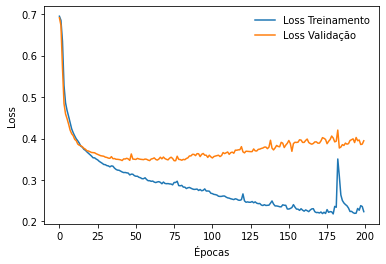

In [16]:

def train_model(model, train_dl, val_dl, epochs, lr):
    """Treinamento do Modelo"""

    # Inicializa otimizador e critério para calculo da loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # Inicializa listas para loss
    train_losses, val_losses = [], []

    # Itera sobre épocas
    for i in range(epochs):

        # Ativa modo de treinamento
        model.train()

        # Inicializa variável para armazenar loss da época
        training_loss, validation_loss = 0, 0
              
        # Itera sobre batches para treinamento
        for x, y in train_dl:

            # Forward pass
            x = x.long()
            y_hat = model(x)

            # Cálculo da Loss e Backpropagation
            optimizer.zero_grad()
            loss = criterion(y_hat, y.reshape(-1, 1))
            loss.backward()
            optimizer.step()

            # Incremeta loss
            training_loss += loss.item()
        
        # Ativa modo de evaluation
        model.eval()
        
        # Itera sobre batches para validação
        with torch.no_grad():
            for x, y in val_dl:

                # Predição
                x = x.long()
                y_hat = lstm_model(x)
                
                # Cálculo da loss
                loss = criterion(y_hat, y.reshape(-1, 1))
                
                # Incremeta loss
                validation_loss += loss.item()
        
        # Adiciona losses nas listas
        train_losses.append(training_loss/len(train_dl))
        val_losses.append(validation_loss/len(val_dl))
    
    # Apresenta gráfico com loss 
    plt.plot(train_losses, label='Loss Treinamento')
    plt.plot(val_losses, label='Loss Validação')
    plt.legend(frameon=False)
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.show()

# Instancia modelo LSTM
lstm_model = SentAnalysis_LSTM(
    n_hidden=hyper_optim.best_params['n_hidden'],
    n_layers=hyper_optim.best_params['n_layers'],
    k2i=w2v_model.wv.key_to_index,
    weights_matrix=weights_tensor,
    threshold=hyper_optim.best_params['threshold']
)

# Realiza treinamento do modelo
train_model(
    model=lstm_model,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=hyper_optim.best_params['epochs'],
    lr=hyper_optim.best_params['lr']
)

# Salva modelo para uso futuro (Pesos e Estrutura completa)
torch.save(lstm_model.state_dict(), 'lstm_model_weights.pth')
torch.save(lstm_model, 'lstm_model.pth')



Observando o gráfico acima podemos perceber que após, aproximadamente, 60 épocas a loss (erro) para o conjunto de validação apresenta leve incremento enquanto a loss para o conjunto de treinamento continua reduzindo. Este comportamento evidencia a ocorrência de overfitting, sendo o momento que o modelo começa a perder a sua capacidade de generalização e se ajusta demais às features do conjunto de treinamento. A seguir realizaremos a análise da acurácia sobre o conjunto de teste, para termos uma melhor ideia de como o modelo irá se comportar na classificação de revisões não utilizadas para o treinamento e otimização.


## Análise de acurácia
---

Após realizarmos o treinamento do modelo e a otimização de seus hiperparâmetros, iremos apurar a sua acurácia sobre revisões não utilizadas em seu desenvolvimento.

In [17]:

# Rodar modelo treinado sobre o conjunto de teste
def test_metrics(model, train_dl, val_dl, test_dl):
    """"""

    # Inicializa contadores
    train_correct, train_total = 0, 0
    val_correct, val_total = 0, 0
    test_correct, test_total = 0, 0

    # Define critério para cálculo da loss
    criterion = nn.BCELoss()
    
    # Ativa modo de evaluation
    model.eval()
    with torch.no_grad():
    
        # Loop Dados Treinamento
        for x, y in train_dl:

            # Predição
            x = x.long()
            y_hat = model(x)
            y_pred = torch.where(y_hat >= model.threshold, 1, 0)

            # Cálculo da loss
            train_loss = criterion(y_hat, y.reshape(-1, 1))
            
            # Atualização dos contadores
            train_correct += (y_pred == y.reshape(-1, 1)).float().sum()
            train_total += y.shape[0]
        
        # Loop Dados Validação
        for x, y in val_dl:

            # Predição
            x = x.long()
            y_hat = model(x)
            y_pred = torch.where(y_hat >= model.threshold, 1, 0)

            # Cálculo da loss
            val_loss = criterion(y_hat, y.reshape(-1, 1))
            
            # Atualização dos contadores
            val_correct += (y_pred == y.reshape(-1, 1)).float().sum()
            val_total += y.shape[0]

        # Loop Dados Teste
        for x, y in test_dl:

            # Predição
            x = x.long()
            y_hat = model(x)
            y_pred = torch.where(y_hat >= model.threshold, 1, 0)

            # Cálculo da loss
            test_loss = criterion(y_hat, y.reshape(-1, 1))
            
            # Atualização dos contadores
            test_correct += (y_pred == y.reshape(-1, 1)).float().sum()
            test_total += y.shape[0]
    
    # Calcula acurácias
    acc_train = (train_correct/train_total).detach().numpy()
    acc_val = (val_correct/val_total).detach().numpy()
    acc_test = (test_correct/test_total).detach().numpy()

    # Cria dataframe e apresenta dados
    metrics = {
        'Conjunto': ['Treino', 'Validação', 'Teste'], 
        'Acurácia': [acc_train, acc_val, acc_test], 
        'Loss': [train_loss.item(), val_loss.item(), test_loss.item()]
    }

    # Apresenta acurácia e loss
    print('Acurácia e Loss para Conjuntos de Treino, Validação e Teste:\n')
    print(pd.DataFrame(metrics))


# Apresenta métricas de treino, validação e teste
test_metrics(lstm_model, train_dl, val_dl, test_dl)


Acurácia e Loss para Conjuntos de Treino, Validação e Teste:

    Conjunto   Acurácia      Loss
0     Treino  0.9074857  0.210192
1  Validação     0.8436  0.336035
2      Teste    0.84584  0.442359



Novamente fica clara a ocorrência de overfitting na classificação realizada pelo modelo. Neste caso o overfitting está evidenciado não apenas pela loss (erro) do conjunto de validação, mas também pelas acurácias (porcentegem de acertos) de validação e teste. Podemos perceber que a acurácia de treino é superior as acurácias de validação e teste.


## Carregando o modelo treinado e realizando classificações
---

As células abaixo permitem carregar o modelo treinado e realizar a classificação de novas revisões por meio do método `predict()`


In [18]:

# Leitura da matriz de vetores densos
with open("pkl/bigrams.pkl", "rb") as f:
    bigrams = pickle.loads(f.read())

# Leitura da matriz de vetores densos
with open("pkl/trigrams.pkl", "rb") as f:
    trigrams = pickle.loads(f.read())

# Carrega modelo treinado
lstm_model = torch.load('lstm_model.pth')


In [19]:

# Insere Label
phrase = 'I loved this movie so much. Much more than I expeected, would recommend to anyone'

# Recupera label
label = lstm_model.predict(
    phrase=phrase,
    bigrams=bigrams, 
    trigrams=trigrams
)

# Apresenta classificação:
print(f'Label (0=neg, 1=pos) = {label}')


Label (0=neg, 1=pos) = 1
